In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import glob
import os

from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cartopy

import sys
sys.path.append('scripts')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [4]:
datadir='data/'

dds = {s:{} for s in ['CM4','ESM4']}
for mod in dds:
    # Load the static grid data
    if mod == 'CM4':
        subdir = 'CM4_piControl_C'
        grid = xr.open_dataset(datadir+subdir+'_ocean_monthly.static.nc')
    elif mod == 'ESM4':
        subdir = 'ESM4_piControl_D'
        grid = xr.open_dataset(datadir+subdir+'_ocean_monthly.static.nc')
    else:
        print('grid is not available for'+mod)
        
    grid = grid[['geolon','geolat','wet','areacello']].rename({'xh':'x', 'yh':'y', 'geolon':'lon', 'geolat':'lat'})
    ds_so = grid.where(grid.lat<-30,drop=True)
    
    ds_so['shlf_mask'] = xr.open_dataset(datadir+mod+'_1000m_Isobath_Contour_Transport_Masks.nc')\
                            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)
    dds[mod] = ds_so

In [5]:
north = -30.0
north_str = str(abs(north)).replace('.','')+'S'
lstr = 'sigma2'
val = 37.05
dl=0.1

var = 'Fmap_decomposed_%s_%s_at%s'%(lstr, str(dl).replace('.','').ljust(3, '0'),('%.2f'%val).replace('.',''))
dset = '_southof%s_%s'%(north_str,var)

In [6]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']

ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        if exp == 'control':
            head = '%s_%s'%(mod,exp)
            yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
            yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
            tstr = '%sto%s'%(yr_st,yr_ed)
            filepath = datadir+head+'_so_'+tstr+dset+'.nc'
            print('Loading '+os.path.basename(filepath))
            ddict_exp[exp] = xr.open_dataset(filepath)
        else:
            dss = []

            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                head = '%s_%s_%s'%(mod,exp,mem)
                if mod=='CM4':
                    yr_st,yr_ed = '0051','0070'
                elif mod=='ESM4':
                    if mem=='101':
                        yr_st,yr_ed = '0151','0170'
                    else:
                        yr_st,yr_ed = '0051','0070'
                
                tstr = '%sto%s'%(yr_st,yr_ed)
                filepath = datadir+head+'_so_'+tstr+dset+'.nc'
                print('Loading '+os.path.basename(filepath))
                ds = xr.open_dataset(filepath)
                ds['mem'] = int(mem)
                dss.append(ds)
            ddict_exp[exp] = xr.concat(dss, dim='mem')
    ddict[mod] = ddict_exp

Loading CM4_control_so_0281to0380_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwater_251_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwater_290_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwater_332_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_stress_251_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_stress_290_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_stress_332_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwaterstress_251_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwaterstress_290_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading CM4_antwaterstress_332_so_0051to0070_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading ESM4_control_so_0121to0220_southof300S_Fmap_decomposed_sigma2_010_at3705.nc
Loading ESM4_antwater_101_so_

### Figure 10

In [7]:
vrange=[-5e-6,5e-6]
cbticks=np.arange(-5e-6,6e-6,1e-6)
cmap='RdBu_r'

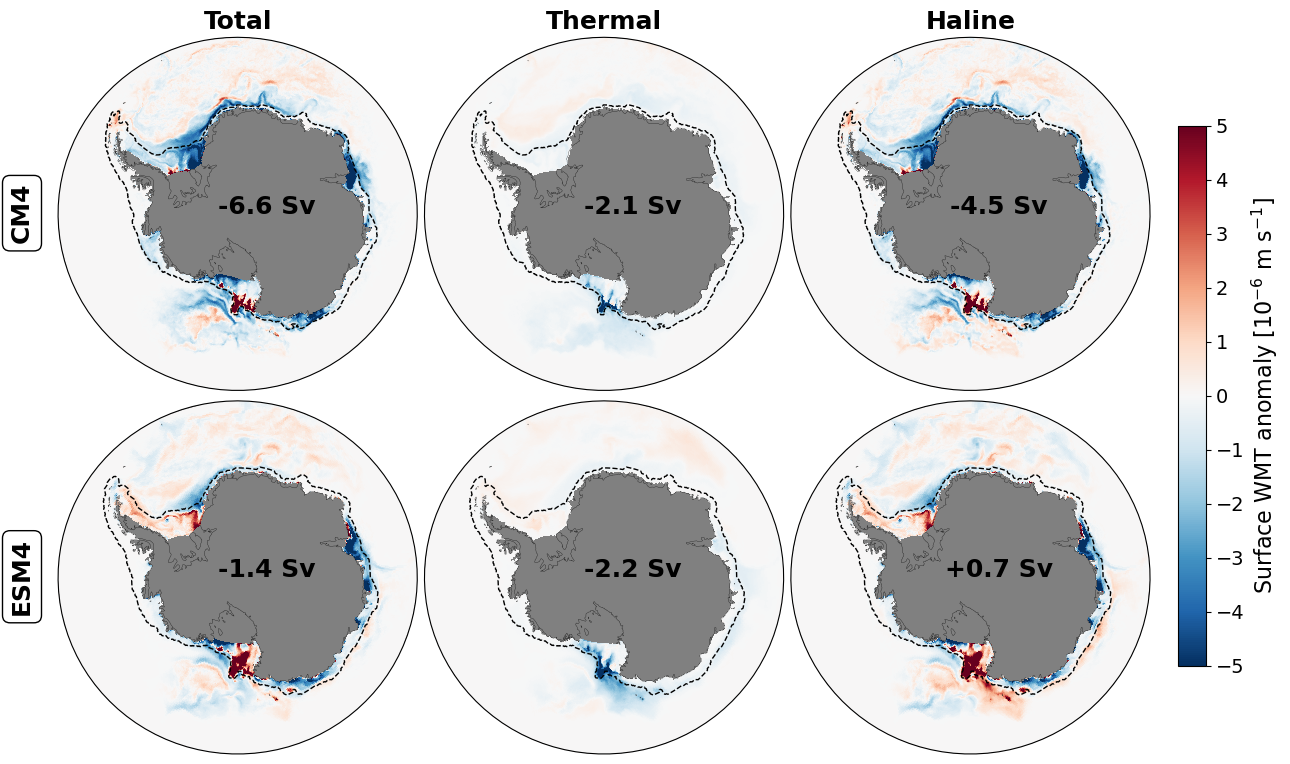

In [8]:
exp = 'antwater'
titstr = ['Total', 'Thermal', 'Haline']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,9), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)
for i, mod in enumerate(ddict):
    for j, var in enumerate(['total','heat','salt']):
        da = (ddict[mod][exp][var].mean('mem') - ddict[mod]['control'][var])*1e6
        axes[i,j].coastlines(lw=0.2)
        axes[i,j].set_extent([-300, 60, -57, -90], cartopy.crs.PlateCarree())
        axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
        p =  da.where(dds[mod].wet==1).plot(ax=axes[i,j], x='x', y='y', vmin=-5, vmax=5, cmap=cmap, 
                                            transform=cartopy.crs.PlateCarree(), add_colorbar=False)        
        cs = dds[mod].shlf_mask.fillna(0).plot.contour(ax=axes[i,j], x='x', y='y', linewidths=1, colors='k',
                                                       transform=cartopy.crs.PlateCarree(), 
                                                       add_labels=False,levels=[0,1,2])
        for c in cs.collections:
            c.set_linestyle('dashed')
        
        if i==0:
            axes[i,j].set_title(var.capitalize() if var=='total' else titstr[j], fontsize=18, fontweight='bold')
            
        if j==0:
            axes[i,j].annotate(mod,xy=(-0.1, 0.5), xycoords=axes[i,j].transAxes, 
                               textcoords='offset points',bbox=dict(boxstyle="round", fc="w"),
                               fontsize=18, fontweight='bold',
                               ha='center', va='center', rotation=90)
        swmt_int = np.round((da*1e-12*dds[mod]['areacello']).sum(['x','y']).values,1)
        axes[i,j].add_artist(AnchoredText(('%.1f Sv' if swmt_int<0 else '+%.1f Sv')%swmt_int,
                             loc='center', prop={'size': 18, 'weight': 'bold'}, frameon=False,
                             bbox_to_anchor=(0.58, 0.52), bbox_transform=axes[i,j].transAxes))
            
cax = fig.add_axes([0.9, 0.2 , 0.02, 0.6])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-5,6,1),orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label(r'Surface WMT anomaly [10$^{-6}$ m s$^{-1}$]', fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.savefig('swmt_map.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 10**: Spatial distribution of $G_{srf}$ anomalies evaluated at the upper density bound of the AABW ($\sigma_2$ = 37.05) in CM4 (top) and ESM4 (bottom). The anomalies are calculated from the average over the years 51-70 of the Antwater experiment minus the 100-year average of the Control. Total anomalies (left) are compared to anomalies in the thermal (middle) and haline component (right). The area-integrated change in $G_{srf}$ is printed in the center of each map and corresponds to the difference between Control and Antwater in Figure 7. The 1000-m isobath is shown as black dashed contours which delineates the Antarctic shelf from the open ocean.

### Comparison plots

In [9]:
box_titel_str = 'total = %.1f Sv\npos. = %.1f Sv\nneg. = %.1f Sv'

In [10]:
mod = 'ESM4'
exp = 'antwater'

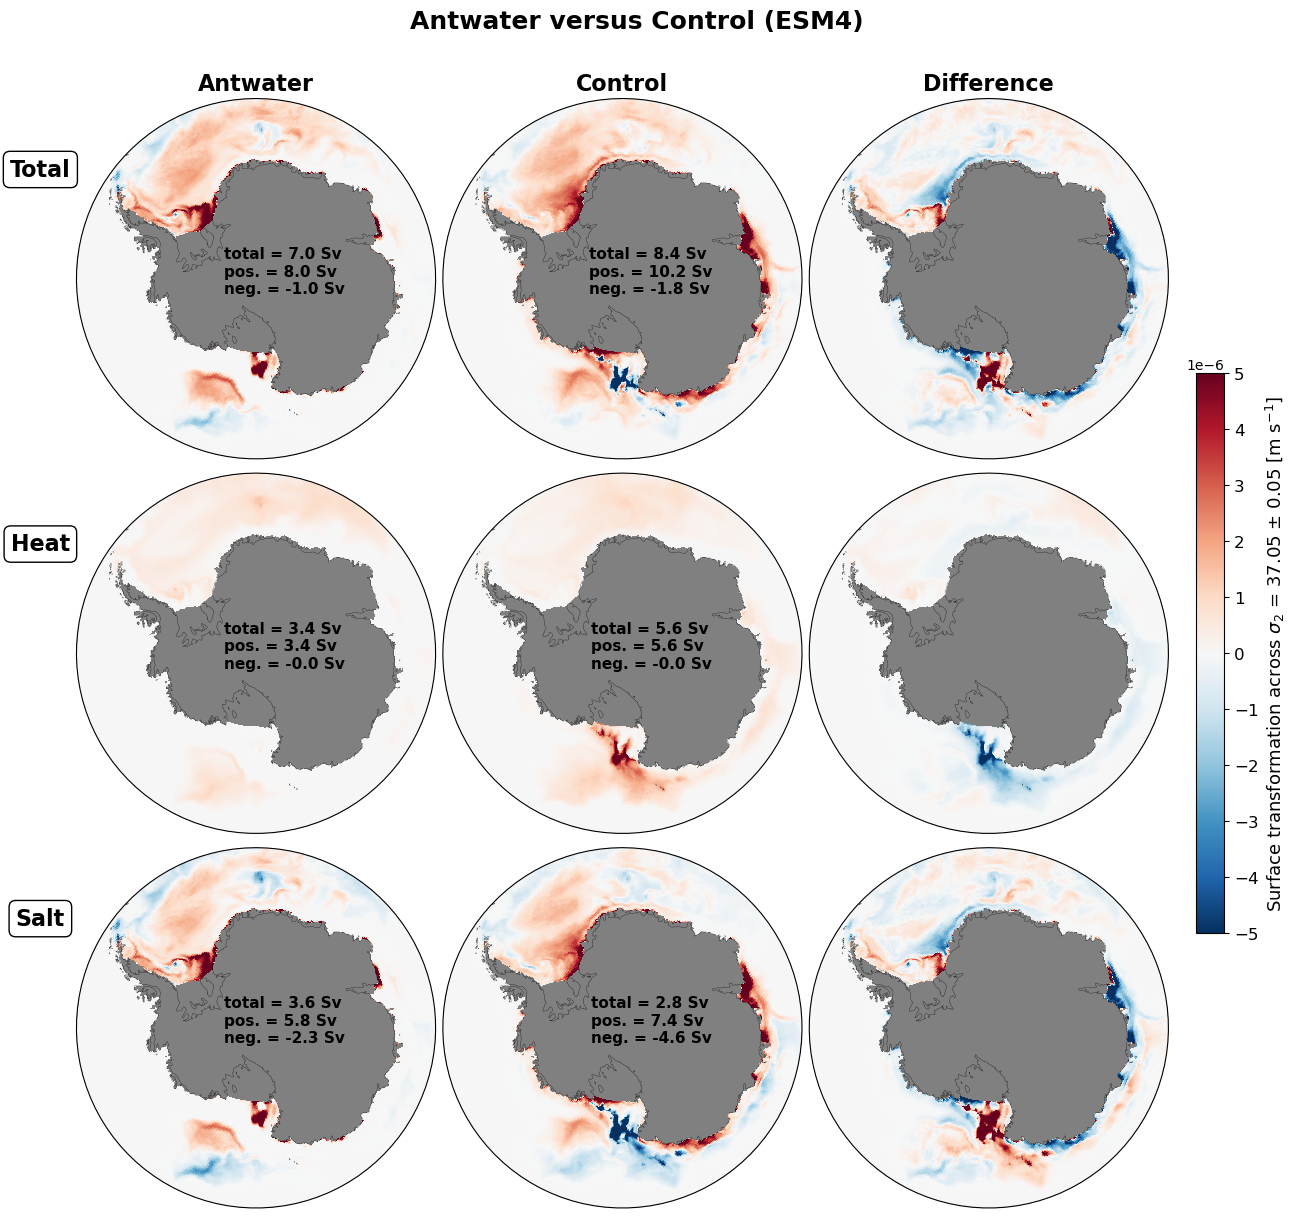

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,14), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)
for j in range(0,3):
    for i, var in enumerate(['total','heat','salt']):
        
        if j==0:
            da = ddict[mod][exp][var].mean('mem')
            #dac = mndict[mod][exp].sigma2.mean('mem')
        elif j==1:
            da = ddict[mod]['control'][var]
            #dac = mndict[mod]['control'].sigma2
        else:
            da = ddict[mod][exp][var].mean('mem') - ddict[mod]['control'][var]
            #dac = mndict[mod][exp].sigma2.mean('mem')
            
        axes[i,j].coastlines(lw=0.2)
        axes[i,j].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
        axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
        p =  da.where(dds[mod].wet==1).plot(ax=axes[i,j], x='x', y='y', vmin=vrange[0], vmax=vrange[1], cmap=cmap, 
                                            transform=cartopy.crs.PlateCarree(), add_colorbar=False)
        #cs = dac.plot.contour(ax=axes[i,j], x='x', y='y', levels=clevels,
        #                      linewidths=1, colors='y',transform=cartopy.crs.PlateCarree())
        
        if j < 2:
            axes[i,j].add_artist(AnchoredText(box_titel_str% \
                                (np.round((da*1e-6*dds[mod]['areacello']).sum(['x','y']).values,1),
                                 np.round((da.where(da>0)*1e-6*dds[mod]['areacello']).sum(['x','y']).values,1),
                                 np.round((da.where(da<0)*1e-6*dds[mod]['areacello']).sum(['x','y']).values,1)),
                                              loc='center', prop={'size': 11, 'weight': 'bold'}, frameon=False,
                                              bbox_to_anchor=(0.58, 0.52), bbox_transform=axes[i,j].transAxes))
            
        if j==0:
            axes[i,j].annotate(var.capitalize(),xy=(-0.1, 0.8), xycoords=axes[i,j].transAxes, 
                               textcoords='offset points',bbox=dict(boxstyle="round", fc="w"),
                               fontsize=16, fontweight='bold',
                               ha='center', va='center')
        if var=='total':
            axes[i,j].set_title(exp.capitalize() if j==0 else 'Control' if j==1 else 'Difference',
                                fontsize=16, fontweight='bold')
        
cax = fig.add_axes([0.9, 0.3 , 0.02, 0.4])
cb = fig.colorbar(p, cax=cax, ticks=cbticks,orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label(r'Surface transformation across $\sigma_%s$ = %.2f $\pm$ %.2f [m s$^{-1}$]'\
             %(lstr[-1],val,dl/2), fontsize=13)
cb.ax.tick_params(labelsize=12)

fig.suptitle('%s versus Control (%s)'%(exp.capitalize(),mod),fontweight='bold',fontsize=18,y=0.96)
plt.show()